In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# create an initial random forest model, as given in the Titanic Tutorial (by Alexis Cook)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)

pred_train = model.predict(X)
print('Train Set Accuracy: {:.3f}'.format(accuracy_score(y, pred_train)))

#X_test = pd.get_dummies(test_data[features])
#predictions = model.predict(X_test)

#output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
#output.to_csv('submission.csv', index=False)
#print("Your submission was successfully saved!")

Train Set Accuracy: 0.816


Text(0.5, 1.0, 'Variable Importance')

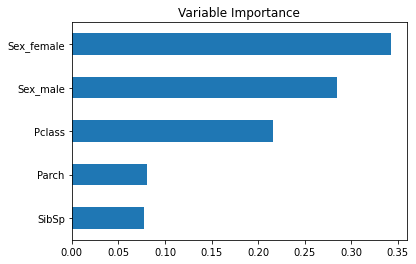

In [5]:
# plot the feature importance of the first random forest model

import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = model.feature_names_in_

forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.barh(ax=ax)
ax.set_title("Variable Importance")

In [6]:
# find missing values in training data

train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# find missing values in test data

test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [8]:
# create another random forest modeling with the Embarked variable also included

features2 = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]

# drop the two rows with missing values for Embarked
train_data2 = train_data[features2+["Survived"]].dropna()    

y2 = train_data2["Survived"]

X2 = pd.get_dummies(train_data2[features2])
#X_test2 = pd.get_dummies(test_data[features2])

model2 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model2.fit(X2, y2)

pred_train2 = model2.predict(X2)
print('Train Set Accuracy: {:.3f}'.format(accuracy_score(y2, pred_train2)))

Train Set Accuracy: 0.814


Text(0.5, 1.0, 'Variable Importance')

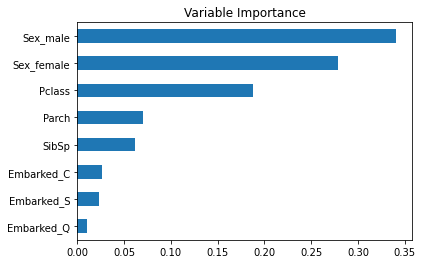

In [9]:
# plot feature importance for second model

importances = model2.feature_importances_
feature_names = model2.feature_names_in_

forest_importances2 = pd.Series(importances, index=feature_names)
forest_importances2.sort_values(inplace=True)

fig, ax = plt.subplots()
forest_importances2.plot.barh(ax=ax)
ax.set_title("Variable Importance")

In [10]:
# create another random forest model using cross-validation to tune the parameters

from sklearn.model_selection import GridSearchCV

max_depths = np.arange(1, 10).tolist()
n_est = np.arange(20, 200, step = 20).tolist()
grid_params = {'n_estimators': n_est, 'max_depth':max_depths}

rf2 = RandomForestClassifier()

rf2cv = GridSearchCV(rf2, param_grid=grid_params, 
                     scoring='accuracy')

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
rf2cv.fit(X, np.ravel(y))  #used np.ravel to make y_train a horizontal 1D array because of a warning

pred_train = rf2cv.predict(X)
print('Train Set Accuracy: {:.3f}'.format(accuracy_score(y, pred_train)))

Train Set Accuracy: 0.814


Text(0.5, 1.0, 'Variable Importance')

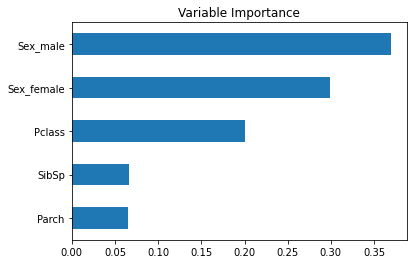

In [11]:
importances = rf2cv.best_estimator_.feature_importances_
feature_names = rf2cv.feature_names_in_

forest_importances3 = pd.Series(importances, index=feature_names)
forest_importances3.sort_values(inplace=True)

fig, ax = plt.subplots()
forest_importances3.plot.barh(ax=ax)
ax.set_title("Variable Importance")

In [12]:
# make predictions on the test data for submission

X_test = pd.get_dummies(test_data[features])
predictions = rf2cv.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
#print("Your submission was successfully saved!")